# DATA SCIENCE PROJECT E9
## KAGGLE - Stanford Ribonanza RNA Folding
We are implementing a model created by user greySnow on Kaggle: https://www.kaggle.com/code/shlomoron/srrf-transformer-tpu-training/notebook with multiple alterations. These alterations include mainly simplifcations to the model in order to be able to run it on our computers. We decided to make some changes once we took into account the limited computational power of our computers.

### Step 1: Importing libraries and decoding data

First of all, we will import all of the necessary libraries for building our model. Some of these libraries may need to be additionally installed.

In [55]:
from pathlib import Path # For 
import os # For interacting with the operating system
import numpy as np # For numerical operations
import pandas as pd # For data manipulation
import matplotlib.pyplot as plt # For data visualization
%matplotlib inline

import platform # For determining the platform the notebook is running on
import tensorflow as tf # For machine learning
import shutil # For file operations
import gc # For garbage collection
import math
import itertools # For iterating through hyperparameters

In [56]:
# !pip install tensorflow
# (etc)

In [57]:
PAD_x = 0.0
PAD_y = np.nan
X_max_len = 206
batch_size = 256
val_batch_size = 512

num_vocab = 5
hidden_dim = 100

In [58]:
# Here we set a desired precision policy, that defines how tensorflow will handle numerical precision for operations. 
policyConfig = 'float32'
policy = tf.keras.mixed_precision.Policy(policyConfig)
tf.keras.mixed_precision.set_global_policy(policy)

In [59]:
# From Kaggle
# Setting up the TensorFlow environment for training a model on a Tensor Processing Unit (TPU)
tpu = None
try: # Attempting to connect to a local TPU and if succesful, setting up a distributed training strategy for leveraging TPU's parallel computing capabilities. 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
    print("REPLICAS: ", strategy.num_replicas_in_sync)
except: # If no TPU found, set up a default strategy (training on a GPU)
    strategy = tf.distribute.get_strategy()

In [60]:
# From Kaggle
# Defining the filepath and file names for our TFRecord files.
tffiles_path = 'tfrfile'
tffiles = ['{}/{:03d}.tfrecord'.format(tffiles_path, idx) for idx  in range(164)]

In [61]:
# From Kaggle, modified according to our TFRecord files.
# A method for decoding the TFRecord files made in the notebook "CVStoTFRecords.ipynb"
def decode_tfrec(record_bytes):
    schema = {}
    schema["id"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["seq"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["dataset_name_2A3"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["dataset_name_DMS"] = tf.io.VarLenFeature(dtype=tf.string)
    schema["reactivity_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_error_2A3"] = tf.io.VarLenFeature(dtype=tf.float32)
    schema["reactivity_error_DMS"] = tf.io.VarLenFeature(dtype=tf.float32)
    features = tf.io.parse_single_example(record_bytes, schema)

    sample_id = tf.sparse.to_dense(features["id"])
    seq = tf.sparse.to_dense(features["seq"])
    dataset_name_2A3 = tf.sparse.to_dense(features["dataset_name_2A3"])
    dataset_name_DMS = tf.sparse.to_dense(features["dataset_name_DMS"])
    reactivity_2A3 = tf.sparse.to_dense(features["reactivity_2A3"])
    reactivity_DMS = tf.sparse.to_dense(features["reactivity_DMS"])
    reactivity_error_2A3 = tf.sparse.to_dense(features["reactivity_error_2A3"])
    reactivity_error_DMS = tf.sparse.to_dense(features["reactivity_error_DMS"])

    out = {}
    out['seq']  = seq
    out['reactivity_2A3']  = reactivity_2A3
    out['reactivity_DMS']  = reactivity_DMS
    return out

In [62]:
# From Kaggle
# A method for importing the TFRecord data
def get_tfrec_dataset(tffiles, shuffle, batch_size, cache = False, calculate_sample_num = True, to_repeat = False):
    ds = tf.data.TFRecordDataset(
        tffiles, num_parallel_reads=tf.data.AUTOTUNE, compression_type = 'GZIP').prefetch(tf.data.AUTOTUNE)

    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    ds = ds.map(concat_target, tf.data.AUTOTUNE)

    if cache:
        ds = ds.cache()

    samples_num = 0
    if calculate_sample_num:
        samples_num = ds.reduce(0, lambda x,_: x+1).numpy()        

    if shuffle:
        if shuffle == -1:
            ds = ds.shuffle(samples_num, reshuffle_each_iteration = True)
        else:
            ds = ds.shuffle(shuffle, reshuffle_each_iteration = True)

    if to_repeat:
        ds = ds.repeat()
    
    
    if batch_size:
        ds = ds.padded_batch(
            batch_size, padding_values=(PAD_x, PAD_y), padded_shapes=([X_max_len],[X_max_len, 2]), drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds, samples_num

In [63]:
val_len = 5

val_files = tffiles[:val_len]

train_files = tffiles[val_len:]

In [64]:
print(train_files)

['tfrfile/005.tfrecord', 'tfrfile/006.tfrecord', 'tfrfile/007.tfrecord', 'tfrfile/008.tfrecord', 'tfrfile/009.tfrecord', 'tfrfile/010.tfrecord', 'tfrfile/011.tfrecord', 'tfrfile/012.tfrecord', 'tfrfile/013.tfrecord', 'tfrfile/014.tfrecord', 'tfrfile/015.tfrecord', 'tfrfile/016.tfrecord', 'tfrfile/017.tfrecord', 'tfrfile/018.tfrecord', 'tfrfile/019.tfrecord', 'tfrfile/020.tfrecord', 'tfrfile/021.tfrecord', 'tfrfile/022.tfrecord', 'tfrfile/023.tfrecord', 'tfrfile/024.tfrecord', 'tfrfile/025.tfrecord', 'tfrfile/026.tfrecord', 'tfrfile/027.tfrecord', 'tfrfile/028.tfrecord', 'tfrfile/029.tfrecord', 'tfrfile/030.tfrecord', 'tfrfile/031.tfrecord', 'tfrfile/032.tfrecord', 'tfrfile/033.tfrecord', 'tfrfile/034.tfrecord', 'tfrfile/035.tfrecord', 'tfrfile/036.tfrecord', 'tfrfile/037.tfrecord', 'tfrfile/038.tfrecord', 'tfrfile/039.tfrecord', 'tfrfile/040.tfrecord', 'tfrfile/041.tfrecord', 'tfrfile/042.tfrecord', 'tfrfile/043.tfrecord', 'tfrfile/044.tfrecord', 'tfrfile/045.tfrecord', 'tfrfile/046.tf

In [65]:
# From Kaggle
def concat_target(x):
    reactivity_2A3 = x['reactivity_2A3']
    reactivity_DMS = x['reactivity_DMS']
    target = tf.concat([reactivity_2A3[..., tf.newaxis], reactivity_DMS[..., tf.newaxis]], axis = 1)
    target = tf.clip_by_value(target, 0, 1)
    return x['seq'], target

In [66]:
# Splitting the data into a training dataset and a validation dataset
train_dataset, num_train = get_tfrec_dataset(train_files, shuffle = -1, batch_size = batch_size,
                                                  cache = True, calculate_sample_num = True,
                                            to_repeat = True)

val_dataset, num_val = get_tfrec_dataset(val_files, shuffle = False, batch_size = val_batch_size,
                                                  cache = True, calculate_sample_num = True)
print(num_train)
print(num_val)

162688
5120


In [67]:
batch = next(iter(val_dataset))
batch[0].shape, batch[1].shape

(TensorShape([512, 206]), TensorShape([512, 206, 2]))

### Step 2: Implementing the model 

In [68]:
# From Kaggle
# A class for the transformer block. This is the basis for the transformer neural network.
class transformer_block(tf.keras.layers.Layer):
    # A constructor method for the transormer block class.
    def __init__(self, dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__() # Constructor of the parent class
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim//num_heads)
        self.ffn = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(feed_forward_dim, activation="relu"),
                tf.keras.layers.Dense(dim),
            ]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.supports_masking = True
        

    def call(self, inputs, training, mask):
        att_mask = tf.expand_dims(mask, axis=-1)
        att_mask = tf.repeat(att_mask, repeats=tf.shape(att_mask)[1], axis=-1)

        attn_output = self.att(inputs, inputs, attention_mask = att_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# A class for the positional encoding layer, similar to the encoding layer, but implements positional encoding
class positional_encoding_layer(tf.keras.layers.Layer):
    def __init__(self, num_vocab=5, maxlen=500, hidden_dim=384):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.pos_emb = self.positional_encoding(maxlen-1, hidden_dim)
        self.supports_masking = True

        
    def call(self, x):
        x = tf.cast(x, dtype=tf.float32)  # Ensure input is cast to float32
        x = x * tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32))
        maxlen = tf.shape(x)[-2]
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32)))
        return x + self.pos_emb[:maxlen, :]

    def positional_encoding(self, maxlen, hidden_dim, ):
        depth = hidden_dim/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1)
        return pos_encoding

In [69]:
# From Kaggle
# A loss function, that compares the predicted reactivities to label values
def loss_fn(labels, targets):
    labels_mask = tf.math.is_nan(labels)
    labels = tf.where(labels_mask, tf.zeros_like(labels), labels)
    mask_count = tf.math.reduce_sum(tf.where(labels_mask, tf.zeros_like(labels), tf.ones_like(labels)))
    loss = tf.math.abs(labels - targets)
    loss = tf.where(labels_mask, tf.zeros_like(loss), loss)
    loss = tf.math.reduce_sum(loss)/mask_count
    return loss

In [70]:
# Use the garbage collection functionality to free up resources for model training.
gc.collect()

161808

In [ ]:
# From Kaggle
# A method for creating a transformer model. Compared to the source code, we have removed 4 transformer blocks in order to improve training time.
# We have also reduced the number of hidden dimensions.
def get_model(hidden_dim = 300, max_len = 206):
    with strategy.scope():
        inp = tf.keras.Input([max_len])
        x = inp

        # Adding an encoding layer and a positional encoding layer.
        x = tf.keras.layers.Embedding(num_vocab, hidden_dim, mask_zero=True)(x)
        x = positional_encoding_layer(num_vocab=num_vocab, maxlen=500, hidden_dim=hidden_dim)(x)

        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)

        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)
        x = transformer_block(hidden_dim, 6, hidden_dim*4)(x)

        # A dropout layer that helps prevent overfitting.
        x = tf.keras.layers.Dropout(0.5)(x)
        # A dense layer with 2 units, that produces an output in two classes.
        x = tf.keras.layers.Dense(2)(x)

        model = tf.keras.Model(inp, x)
        loss = loss_fn
        # The non legacy AdamW runs slow on computers with the M2 chip.
        if platform.system() == "Darwin" and platform.processor() == "arm":
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)
        else:
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
        model.compile(loss=loss, optimizer=optimizer, steps_per_execution = 10)
        return model

# Freeing up resources for model training.
tf.keras.backend.clear_session()

# Creating the model and printing out a summary based on the first batch of data
model = get_model(hidden_dim = 100,max_len = X_max_len)
model(batch[0])
model.summary()

### Step 3: Training the model

We started by find the most suitable hyperparameters for the model without overfitting it. The two hyperparameters that we tuned were the numer of epochs and steps per epoch. The values we tried were 10 for N_EPOCHS and 50 and 100 for steps_per_epoch = 100. <br>
<br>
One of the main points that this model could be improved upon is by perfming a more in-depth hyperparameter tuning. One of the possibilities for this to perform grid search, but since training our model takes around 2 hours, then for only the values [5, 10] and [50, 100] for number of epochs and steps per epoch, this would take 8 hours in total. By adding more hyperparameters to check or more values, the grid search time would rise significantly.
Another way to perform hyperparameter optimixation would be to use the Ray Tune library: https://docs.ray.io/en/latest/tune/index.html. This library would allow us to implement a more optimized way of evaluating hyperparameters compared to grid search. this is done by terminating bad runs early, choosing better parameters or even changing the hyperparameters during training.

In [ ]:
N_EPOCHS = 10

N_WARMUP_EPOCHS = 0
LR_MAX = 5e-4
WD_RATIO = 0.05

WARMUP_METHOD = "exp"

In [ ]:
# From Kaggle
# A function for calculating the 
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()
    plt.savefig('learningrate.pdf')

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

In [ ]:
# From Kaggle
# A class for saving the model weights as found from training the model.
save_folder = 'model_weights' # Folder to save the weights to
try:
    os.mkdir(f'{save_folder}')
except:
    pass

class save_model_callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch: int, logs=None):
        if epoch == 3 or (epoch+1)%25 == 0:
            self.model.save_weights(f"{save_folder}/model_epoch_{epoch}.h5")

In [ ]:
steps_per_epoch = 100
val_steps_per_epoch = num_val//val_batch_size
print(steps_per_epoch)
print(val_steps_per_epoch)

Training the model with the best parameters. This step will take about 2 hours in total, about 10 minutes per epoch. The weights found during training are saved using the save_model_callback( ) function. These can then be exported to the inference notebook for testing the model.

In [ ]:
# Training the model with the most suitable parameters
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_steps = val_steps_per_epoch,
    verbose = 2,
    callbacks = [
        save_model_callback(),
        lr_callback,
    ]
)

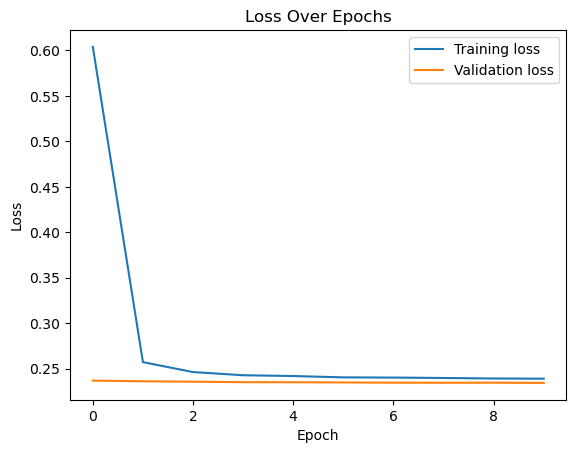

<Figure size 640x480 with 0 Axes>

In [54]:
# Plotting the loss function graph
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")

plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.show()
plt.savefig("loss.pdf", format="pdf")